## Equation of State Generators illustration notebook

First import all of the package that will be used here.

In [1]:
import EOSgenerators.crust_EOS as crust
import EOSgenerators.RMF_EOS as RMF
import TOVsolver.main as main
import matplotlib.pyplot as plt
import numpy as np
import math
from TOVsolver.unit import g_cm_3, dyn_cm_2, km, Msun

### Load crust EOS and prepare interface EOS

Define constants, and load the crust EOS into this notebook, since when we solve the equation of state to TOV equation, we need full scope of the equation of state. Here, crust eos file is 'Tolos_crust_out.txt', while we need to times g_cm_3 for energy density and dyn_cm_2 for pressure, that will be easier for treatment, no need worry about G and c.

Then just connect the crust part with the interface part(the part between core equation of state and crust) by a PolyInterpolate function

In [2]:
Tolos_crust_out = np.loadtxt("Tolos_crust_out.txt")
eps_crust_T_out = Tolos_crust_out[:, 3] * g_cm_3
pres_crust_T_out = Tolos_crust_out[:, 4] * dyn_cm_2
eps_com, pres_com = crust.PolyInterpolate(eps_crust_T_out, pres_crust_T_out)

### Defining the paramters

Defining the free prameters that we need to compute the equation of state, you could check our intro part of documentation or just check the original paper of us about details. [Huang et al,2023](https://arxiv.org/abs/2303.17518)

After defined the equation of state parameters, we could call the 'compute_EOS' function from RMF, to compute full core equation of state.

In [3]:
m_sig = 495.0 / 197.33
m_w = 3.96544
m_rho = 3.86662

g_sigma = math.sqrt(107.5751)
g_omega = math.sqrt(182.3949)
g_rho = math.sqrt(206.4260)

kappa = 3.09114168 / 197.33
lambda_0 = -0.00168015405
zeta = 0.024
Lambda_w = 0.045
theta = np.array(
    [m_sig, m_w, m_rho, g_sigma, g_omega, g_rho, kappa, lambda_0, zeta, Lambda_w]
)
eps, pres = RMF.compute_EOS(eps_com, pres_com, theta)

### Connecting Core and crust EOS

These two line can easily connect the Equation of state we computed for core part by setting the parameters and the crust equation of state, to a full equation of state that prepared for next step output


In [4]:
eps_total = np.array([*eps_com, *eps])
pres_total = np.array([*pres_com, *pres])

Here below is one of the possiblity, use our defined function, 'OutputMR' to compute out what the mass radius curve corresponding to this equation of state.

In [5]:
MR = main.OutputMR("", eps_total, pres_total).T

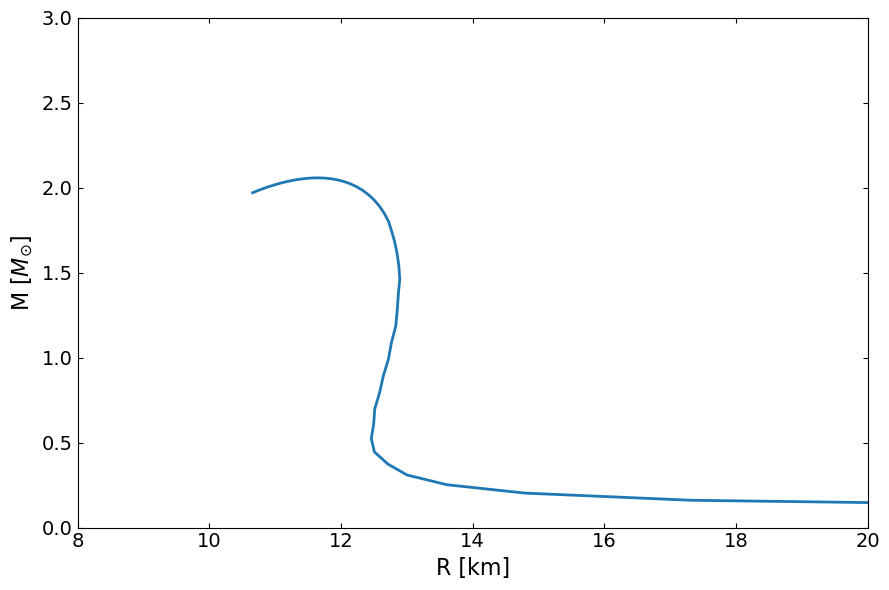

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(MR[0] / km, MR[1] / Msun, lw=2)
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
ax.set_xlim(8.0, 20.0)
ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()

### Illustrating the power of Numba accelerated EoS Generation

We shall now run the same code but with the Numba accelerated version, comparing the times for EoS Generation.

Keep in mind all previous definitions are still valid, all we need to change is a single line of code.


In [7]:
import EOSgenerators.fastRMF_EoS as FastRMF
import time

Tolos_crust_out = np.loadtxt("Tolos_crust_out.txt")
eps_crust_T_out = Tolos_crust_out[:, 3] * g_cm_3
pres_crust_T_out = Tolos_crust_out[:, 4] * dyn_cm_2
eps_com, pres_com = crust.PolyInterpolate(eps_crust_T_out, pres_crust_T_out)

m_sig = 495.0 / 197.33
m_w = 3.96544
m_rho = 3.86662

g_sigma = math.sqrt(107.5751)
g_omega = math.sqrt(182.3949)
g_rho = math.sqrt(206.4260)

kappa = 3.09114168 / 197.33
lambda_0 = -0.00168015405
zeta = 0.024
Lambda_w = 0.045
theta = np.array(
    [m_sig, m_w, m_rho, g_sigma, g_omega, g_rho, kappa, lambda_0, zeta, Lambda_w]
)


### Comparing the time it takes to generate the EoS

The reason why we test the time it takes to generate the EoS here is due to the fact that Numba is compiling the code, and as such the first run will take considerably longer to complete, but all other runs will be greatly faster.

Warning: Do not rerun this cell, as the compilation time will be gone.


In [8]:
### Normal RMF ####

first_run_time_normal = time.time()
eps_fast, pres_fast = RMF.compute_EOS(eps_com, pres_com, theta)
first_run_time_normal = time.time() - first_run_time_normal

time_for_20_runs_normal = time.time()
for _ in range(20):
    eps, pres = RMF.compute_EOS(eps_com, pres_com, theta)
time_for_20_runs_normal = time.time() - time_for_20_runs_normal


##### Fast RMF #####

first_run_time = time.time()
eps_fast, pres_fast = FastRMF.compute_EOS(eps_com, pres_com, theta)
first_run_time = time.time() - first_run_time

time_for_20_runs = time.time()
for _ in range(20):
    eps_fast, pres_fast = FastRMF.compute_EOS(eps_com, pres_com, theta)
time_for_20_runs = time.time() - time_for_20_runs


print(f"--------------------------------------------------------------------------------------")
print(f"|" + " "*84 + "|")
print(f"|" + " "*32 + "Time Comparion Table" + " "*32 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*17 + f"Time for first run  with RMF-Normal  = {first_run_time_normal*1000:6.0f} ms" + " "*19 + "|")
print(f"|" + " "*17 + f"Time for first run  with RMF-Fast    = {first_run_time*1000       :6.0f} ms" + " "*19 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*17 + f"Time for   20  runs with RMF-Normal  = {time_for_20_runs_normal*1000:6.0f} ms" + " "*19 + "|")
print(f"|" + " "*17 + f"Time for   20  runs with RMF-Fast    = {time_for_20_runs*1000       :6.0f} ms" + " "*19 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*17 + f"Time for  all  runs with RMF-Normal  = {(first_run_time_normal + time_for_20_runs_normal)*1000:6.0f} ms" + " "*19 + "|")
print(f"|" + " "*17 + f"Time for  all  runs with RMF-Fast    = {(first_run_time        + time_for_20_runs       )*1000:6.0f} ms (Has Compilation) " + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*17 + f"Time for   1   run  with RMF-Normal  = {time_for_20_runs_normal*1000/20:6.0f} ms  " + " "*17 + "|")
print(f"|" + " "*17 + f"Time for   1   run  with RMF-Fast    = {time_for_20_runs       *1000/20:6.0f} ms" + " "*19 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*30 + f"Total Speed Up = {time_for_20_runs_normal/time_for_20_runs:.2f} x" + " "*30 + "|" )
print(f"--------------------------------------------------------------------------------------")

--------------------------------------------------------------------------------------
|                                                                                    |
|                                Time Comparion Table                                |
|                                                                                    |
|                 Time for first run  with RMF-Normal  =    472 ms                   |
|                 Time for first run  with RMF-Fast    =   2127 ms                   |
|                                                                                    |
|                 Time for   20  runs with RMF-Normal  =   9293 ms                   |
|                 Time for   20  runs with RMF-Fast    =    247 ms                   |
|                                                                                    |
|                 Time for  all  runs with RMF-Normal  =   9765 ms                   |
|                 Time for  all  runs with 

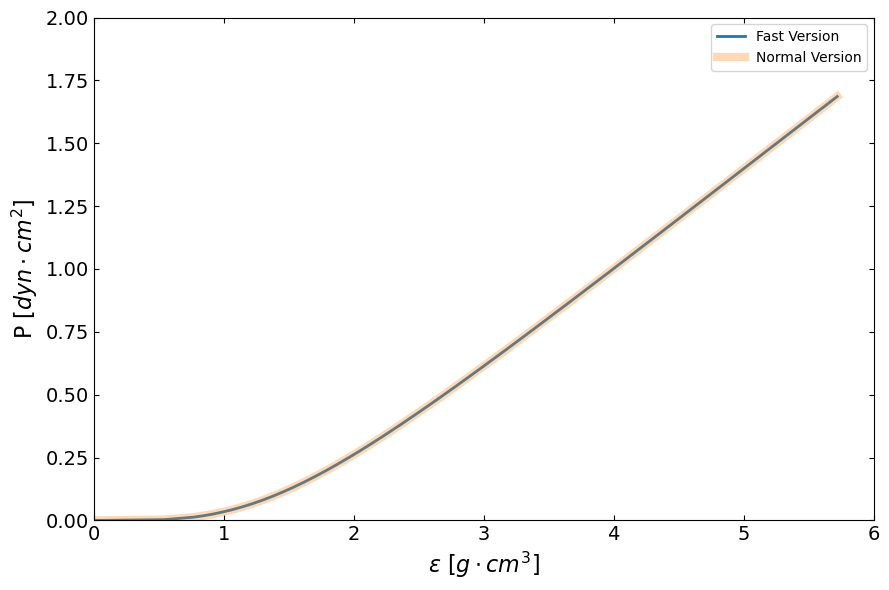

In [9]:
eps_total_fast = np.array([*eps_com, *eps_fast])
pres_total_fast = np.array([*pres_com, *pres_fast])

compare_fig1, ax = plt.subplots(1, 1, figsize=(9,6))

ax.plot(eps_total_fast, pres_total_fast, lw=2, label="Fast Version")
ax.plot(eps_total, pres_total, lw=6, label="Normal Version", alpha=0.3)
ax.set_ylabel(r"P $[dyn \cdot cm^{2}]$", fontsize=16)
ax.set_xlabel(r"$\epsilon$ $[g \cdot cm^{3}]$", fontsize=16)
ax.set_xlim(0, 6)
ax.set_ylim(0, 2)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
plt.legend()
compare_fig1.tight_layout()
plt.show()

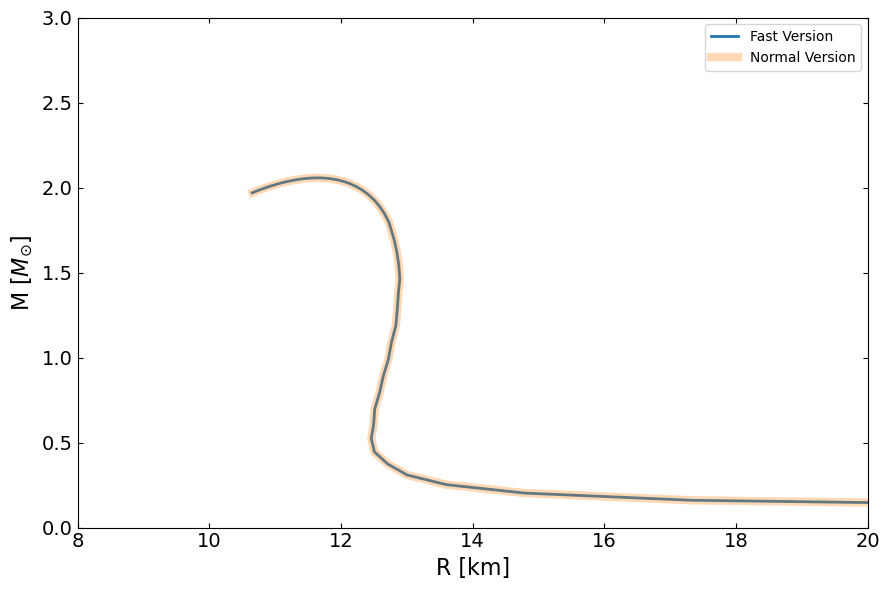

In [10]:
MR_fast = main.OutputMR("", eps_total_fast, pres_total_fast).T

compare_fig2, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(MR_fast[0] / km, MR_fast[1] / Msun, lw=2, label="Fast Version")
ax.plot(MR[0] / km, MR[1] / Msun, lw=6, label="Normal Version", alpha=0.3)
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
ax.set_xlim(8.0, 20.0)
ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
plt.legend()
compare_fig2.tight_layout()
plt.show()